In [4]:
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob
import spacy

In [2]:
# nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/bose/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df = pd.read_csv('../data/jokes.csv', index_col=0)
df.head()

,joke
Unnamed: 0,
0,A dangling participle walks into a bar. Enjoyi...
1,A bar was walked into by the passive voice.
2,"An oxymoron walked into a bar, and the silence..."
3,Two quotation marks walk into a “bar.”
4,"A malapropism walks into a bar, looking for al..."


In [6]:
df['joke'].apply(lambda x: ' '.join(word_tokenize(x)))

Unnamed: 0
0       A dangling participle walks into a bar . Enjoy...
1            A bar was walked into by the passive voice .
2       An oxymoron walked into a bar , and the silenc...
3               Two quotation marks walk into a “ bar . ”
4       A malapropism walks into a bar , looking for a...
                              ...                        
1428    A Neutron Walks Into A Bar And Orders A Beer ....
1429    A Man Walks Out Of A Bar And Meets A Policeman...
1430    A Leprechaun Walks Into A Bar . The Bartender ...
1431    A Man Walks Into A Bar And Says He Wants To Bu...
1432    A Man Walks Into A Bar And Says , `` Ouch , Th...
Name: joke, Length: 1433, dtype: object

Let us analyze the most frequently occuring words (excluding common words such as `bar`, `bartender`, `man`, `walk`, etc, along with common english stopwords)

In [7]:
import re

lemmatizer = WordNetLemmatizer()

stopwords = nltk.corpus.stopwords.words('english')
stopwords += ['walk', 'walks', 'bartender', 'bar', 'walked', 'order', 'joke']
stopwords = set(stopwords)

soup = ' '.join(df['joke']).casefold()

soup = soup.translate(str.maketrans('', '', string.punctuation + string.digits))

tokens = word_tokenize(soup)
tokens = [ token.encode('ascii', 'ignore').decode() for token in tokens if token not in stopwords]
tokens = [token for token in tokens if token]
len(tokens)


24752

In [8]:
from collections import Counter

counter = Counter(tokens)
most_common = counter.most_common()


In [9]:
tok_tagged = nltk.pos_tag(tokens)
tok_tagged_n = [tok for tok, pos in tok_tagged if pos[0] == 'N']

counter = Counter(tok_tagged_n)

top50_n = counter.most_common(50)

In [10]:
top50_n[:10]

[('man', 612),
 ('orders', 299),
 ('beer', 277),
 ('guy', 250),
 ('replies', 198),
 ('asks', 154),
 ('dont', 131),
 ('horse', 114),
 ('beers', 74),
 ('im', 74)]

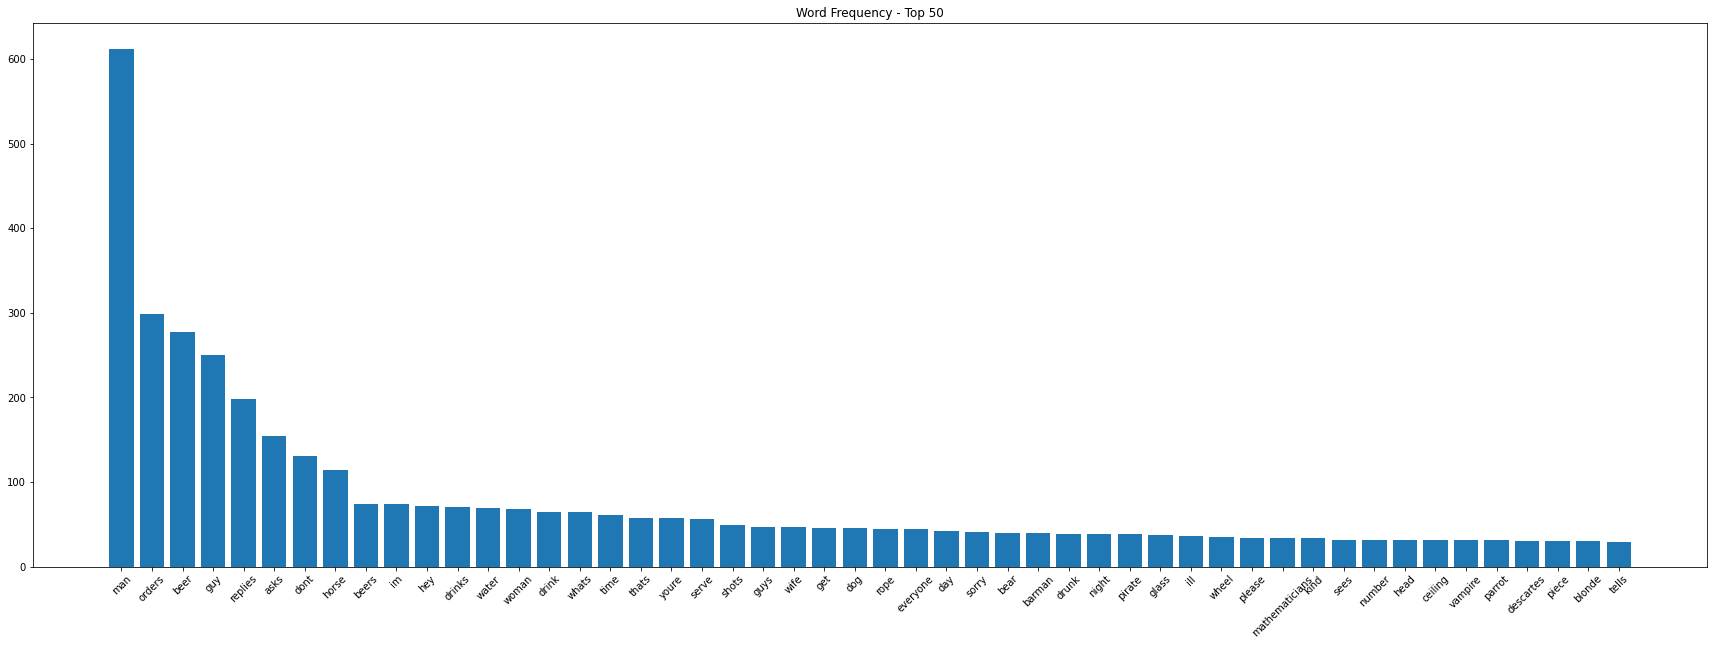

In [11]:
plt.figure(figsize=(30, 10))

plt.bar(x=[i[0] for i in top50_n], height=[i[1] for i in top50_n])
plt.tick_params(axis='x', rotation=45)
plt.title('Word Frequency - Top 50')

plt.savefig('noun_freq_top50.png')
plt.show()


In [12]:
nlp = spacy.load('en_core_web_sm', disable=['parser'])

In [13]:
df['text'] = df['joke'].apply(lambda x: x.lower())  # lower case
                                                    # remove punctuation & digits
df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation + string.digits)))

df['text'] = df['text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x) if not token.is_stop and token.lemma_ not in stopwords]))


df.head()

,joke,text
Unnamed: 0,,
0,A dangling participle walks into a bar. Enjoyi...,dangle participle enjoy cocktail chat evening ...
1,A bar was walked into by the passive voice.,passive voice
2,"An oxymoron walked into a bar, and the silence...",oxymoron silence deafen
3,Two quotation marks walk into a “bar.”,"quotation mark "" """
4,"A malapropism walks into a bar, looking for al...",malapropism look intensive purpose like wolf c...


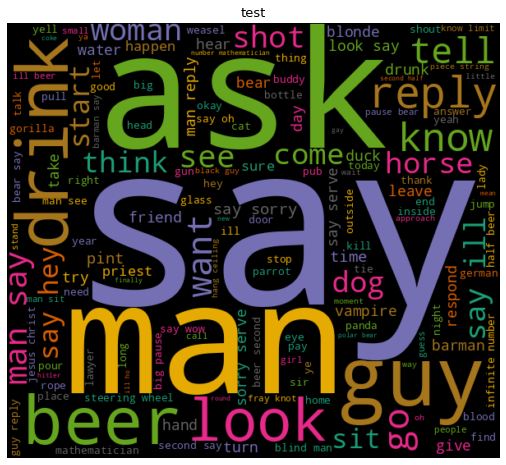

In [14]:
def wordcloud(data,title):
  wc = WordCloud(width=600, height=530, max_words=150,colormap="Dark2").generate(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()


wordcloud(data=' '.join(df['text']), title='test')

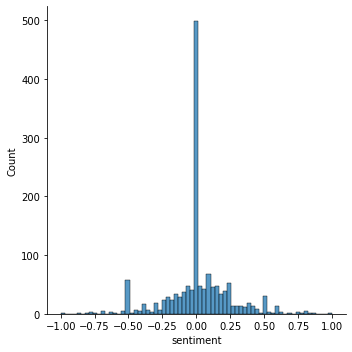

In [15]:
df['sentiment'] = df['joke'].apply(lambda x: TextBlob(x).sentiment.polarity)

sns.displot(data=df, x='sentiment')

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

cc = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords)

model = cc.fit(df['text'])
counts = cc.transform(df['text'])
pd.DataFrame(counts.sum(axis=0), columns=cc.get_feature_names_out()).T.sort_values(0, ascending=False).head(50)
# cc.get_feature_names()

,0
say,1164
man,633
ask,441
guy,377
beer,341
drink,330
reply,287
look,221
know,157
go,150


<AxesSubplot:xlabel='char_count', ylabel='Count'>

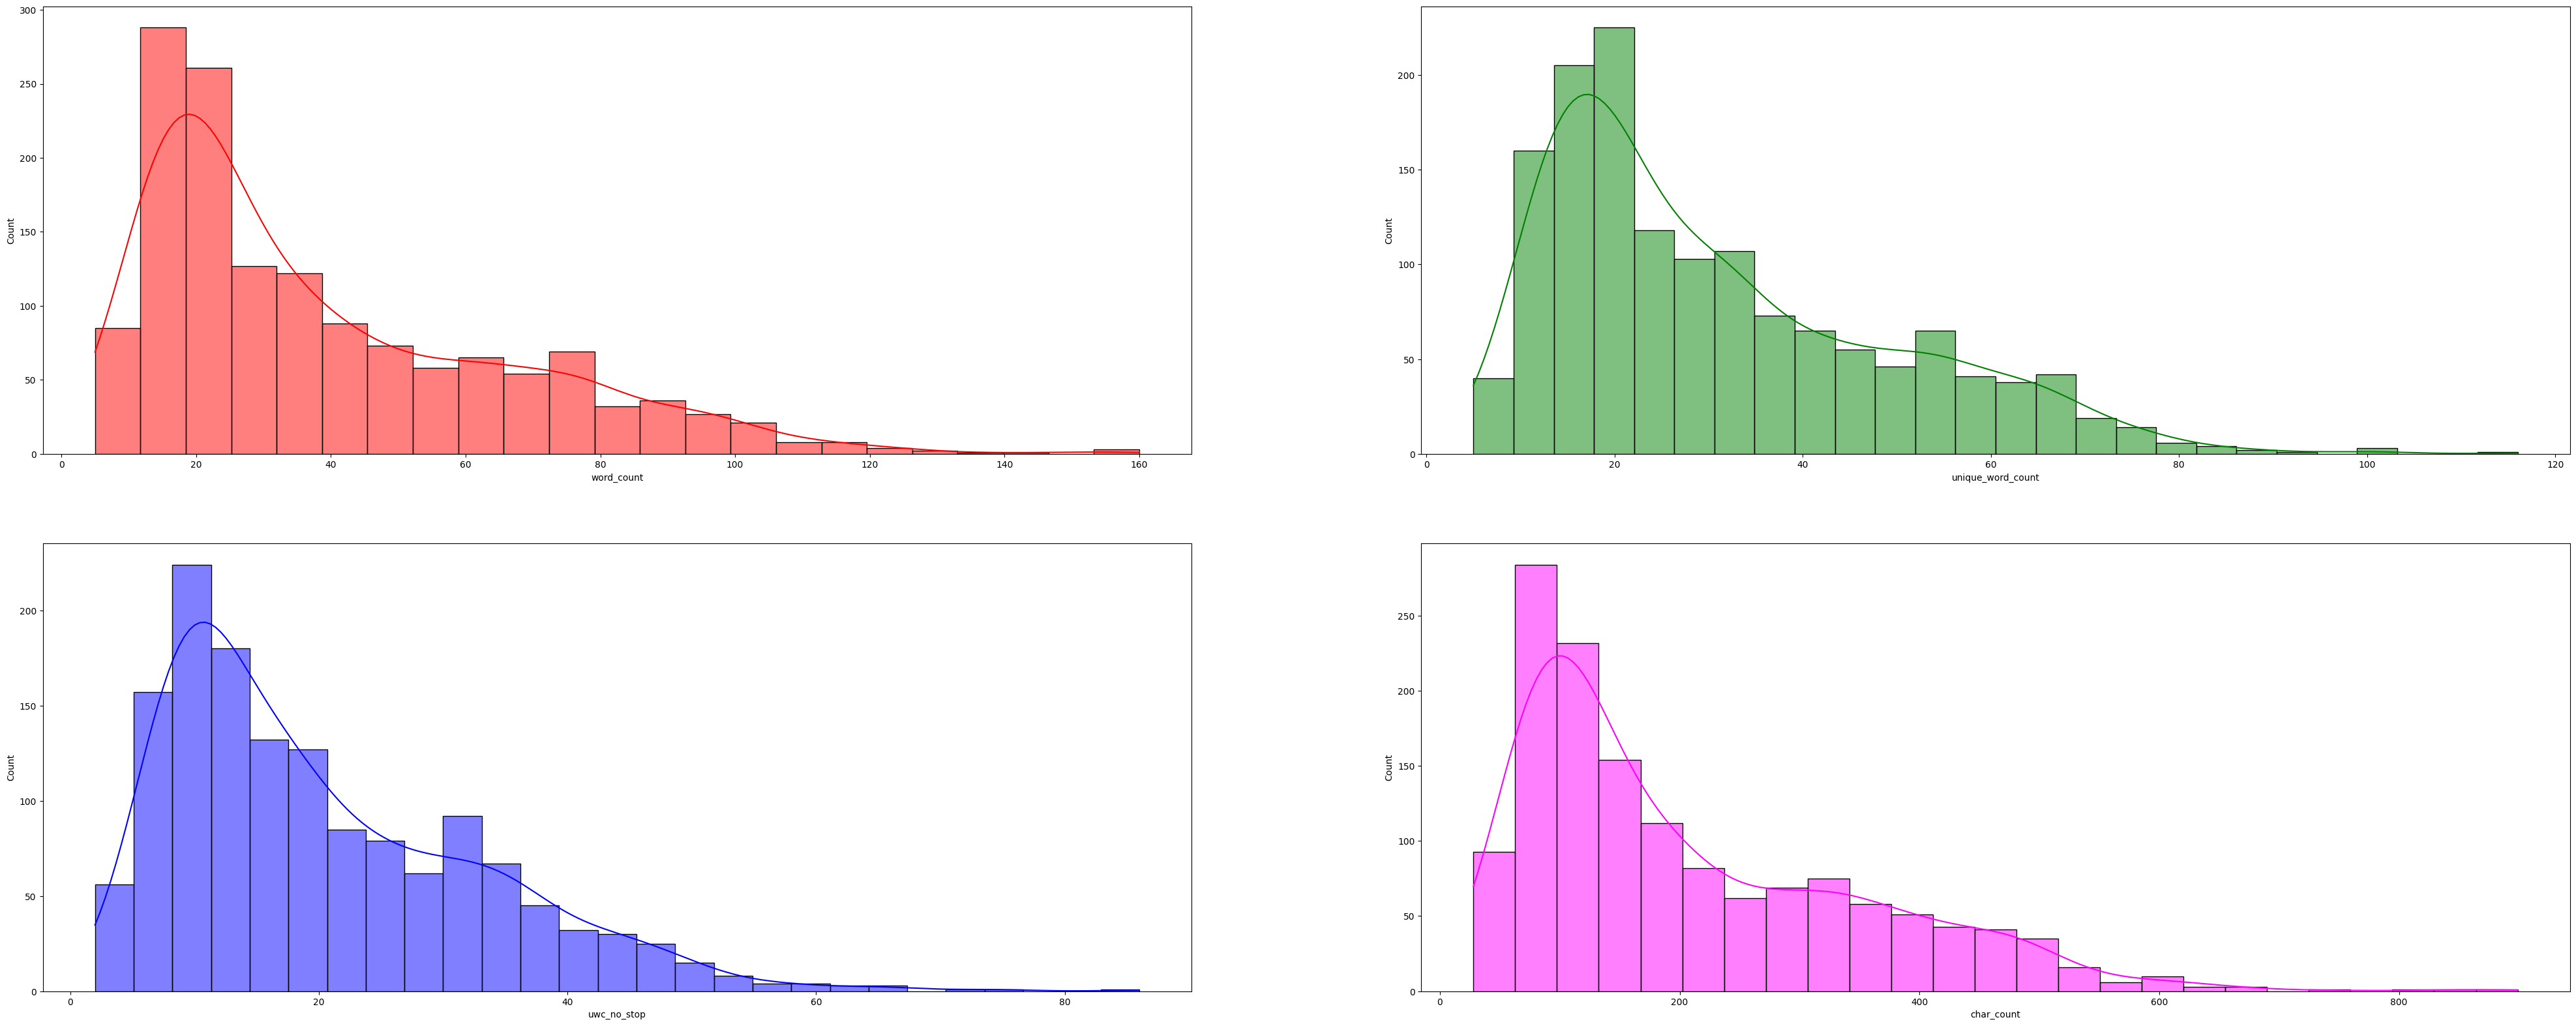

In [25]:
df['word_count'] = df['joke'].apply(lambda x: len(x.split()))
df['unique_word_count'] = df['joke'].apply(lambda x: len(set(x.split())))
df['uwc_no_stop'] = df['joke'].apply(lambda x: len(set([w for w in x.split() if w not in stopwords])))
df['char_count'] = df['joke'].apply(lambda x: len(str(x)))

f, ax = plt.subplots(ncols=2, nrows=2, figsize=(50, 20), dpi=100)

sns.histplot(df['word_count'], kde=True, color='red', ax=ax[0][0])
sns.histplot(df['unique_word_count'], kde=True, color='green', ax=ax[0][1])
sns.histplot(df['uwc_no_stop'], kde=True, color='blue', ax=ax[1][0])
sns.histplot(df['char_count'], kde=True, color='magenta', ax=ax[1][1])